# Previção de Downloads

## Rede Neurias

Redes neurais para modelos de séries temporais têm sido exploradas na literatura [1; 4; 5] e têm demonstrado boas habilidades preditivas. Isso nos motiva a explorar redes neurais para nossas previsões. As duas redes neurais que usaremos é a rede neural feed-forward com um número variável de nós, juntamente com uma rede de memória de longo-curto prazo com um número variável de unidades LSTM. Essas redes são mostradas esquematicamente nas Figs. 4 e 5 no caso de 4 nós e 4 unidades LSTM. Os tutoriais em Refs. [7; 6; 8] foram muito instrutivos para começar a usar esses modelos.

### Neuronios

### Epochs (epocas)

O número de épocas é um hiperparâmetro que define o número de vezes que o algoritmo de aprendizado funcionará em todo o conjunto de dados de treinamento. Uma época significa que cada amostra no conjunto de dados de treinamento teve a oportunidade de atualizar os parâmetros do modelo interno. Uma época é composta por um ou mais lotes.

## Read Data

In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler

import math
from sklearn.metrics import mean_squared_error


import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

In [2]:
np.random.seed(7)
look_back = 1

In [3]:
def create_index_datatime(df):
    
    format = '%Y-%m-%d'
    
    df['data'] = pd.to_datetime(df['data'],format=format).dt.date
    df['anoMes'] = pd.to_datetime(df['data'],format=format).dt.strftime('%Y-%m')
    
    df = df.set_index('data')
    
    return df

In [35]:
# Preparing independent and dependent features
def prepare_data(time_series, n_features):
    dataX, dataY = [],[]
    for i in range(len(time_series)):
        # find the end of this pattern
        end_ix = i + n_features
        
        #Check if we are beyond the sequence
        if end_ix > len(time_series)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = time_series[i:end_ix], time_series[end_ix]
        dataX.append(seq_x)
        dataY.append(seq_y)
    return np.array(dataX), np.array(dataY)

In [13]:
podcasts = create_index_datatime(pd.read_csv('base_geral_mensal_v2.csv',';'))

In [14]:
podcasts.head()

,ano,mes,downloads,titulos_mes,episodios_mes,flagCovid,flagMigracao,P,M,G,...,M_scaled,G_scaled,GG_scaled,jogosBrasileiro_scaled,classicosBrasileiro_scaled,retaFinal_scaled,jogosGrandesB_scaled,jogosCopaAm_scaled,jogosBrasilCopaAm_scaled,anoMes
data,,,,,,,,,,,,,,,,,,,,,
2018-04-01,2018,4,4287.0,1,0.0,0,0,1,0,0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-04
2018-05-01,2018,5,6780.0,1,1.0,0,0,1,0,0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-05
2018-06-01,2018,6,9518.0,2,4.0,0,0,2,0,0,...,0.0,0.0,0.0,0.555556,0.571429,0.0,0.0,0.0,0.0,2018-06
2018-07-01,2018,7,60178.0,2,14.0,0,0,2,0,0,...,0.0,0.0,0.0,0.388889,0.571429,0.0,0.0,0.0,0.0,2018-07
2018-08-01,2018,8,55936.0,2,6.0,0,0,2,0,0,...,0.0,0.0,0.0,0.708333,0.000000,0.0,0.0,0.0,0.0,2018-08


In [15]:
target = 'downloads'

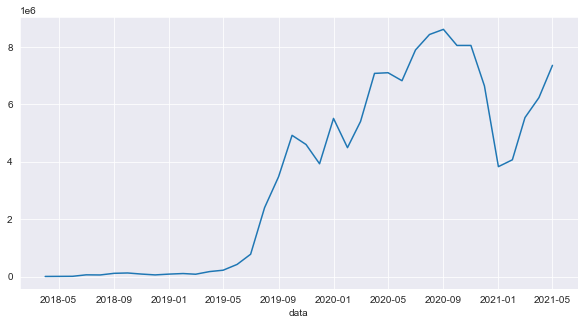

In [18]:
podcasts[target].plot(figsize=(10,5))
plt.show()

### Scaling 

In [7]:
def scaling_data(df):

    scaler = MinMaxScaler(feature_range=(0,1))
    df_scaled = scaler.fit_transform(np.array(df).reshape(-1,1))
    
    return df_scaled,scaler

In [51]:
df = podcasts['downloads'][0:38]
podcasts['downloads_scaled'],scaler = scaling_data(podcasts['downloads'])

In [52]:
podcasts.head(40)

,ano,mes,downloads,titulos_mes,episodios_mes,flagCovid,flagMigracao,P,M,G,...,G_scaled,GG_scaled,jogosBrasileiro_scaled,classicosBrasileiro_scaled,retaFinal_scaled,jogosGrandesB_scaled,jogosCopaAm_scaled,jogosBrasilCopaAm_scaled,anoMes,downloads_scaled
data,,,,,,,,,,,,,,,,,,,,,
2018-04-01,2018,4,4287.0,1,0.0,0,0,1,0,0,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2018-04,0.000000
2018-05-01,2018,5,6780.0,1,1.0,0,0,1,0,0,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2018-05,0.000290
2018-06-01,2018,6,9518.0,2,4.0,0,0,2,0,0,...,0.000000,0.000000,0.555556,0.571429,0.0,0.00,0.000000,0.00,2018-06,0.000608
2018-07-01,2018,7,60178.0,2,14.0,0,0,2,0,0,...,0.000000,0.000000,0.388889,0.571429,0.0,0.00,0.000000,0.00,2018-07,0.006493
2018-08-01,2018,8,55936.0,2,6.0,0,0,2,0,0,...,0.000000,0.000000,0.708333,0.000000,0.0,0.00,0.000000,0.00,2018-08,0.006000
2018-09-01,2018,9,113134.0,6,40.0,0,0,6,0,0,...,0.000000,0.000000,0.986111,0.857143,0.0,0.00,0.000000,0.00,2018-09,0.012645
2018-10-01,2018,10,125114.0,6,32.0,0,0,6,0,0,...,0.000000,0.000000,0.569444,0.571429,0.0,0.00,0.000000,0.00,2018-10,0.014037
2018-11-01,2018,11,86656.0,7,28.0,0,0,7,0,0,...,0.000000,0.000000,0.833333,0.571429,0.0,0.00,0.000000,0.00,2018-11,0.009569
2018-12-01,2018,12,57880.0,8,23.0,0,0,8,0,0,...,0.000000,0.000000,0.138889,0.000000,1.0,0.00,0.000000,0.00,2018-12,0.006226


### Reshape Time series

In [43]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [92]:
columns_name = ['downloads_scaled','CopadoMundo','flagbbb','jogosBrasilCopaAm_scaled','jogosCopaAm_scaled','P_scaled','M_scaled','G_scaled','GG_scaled']

reframed  = series_to_supervised(podcasts[columns_name], 3, 1, True)

In [96]:
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var1(t-2),...,var9(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t)
data,,,,,,,,,,,,,,,,,,,,,
2018-09-01,0.000608,1.0,0.0,0.0,0.0,0.008772,0.0,0.0,0.0,0.006493,...,0.0,0.012645,0,0,0.0,0.0,0.043860,0.0,0.0,0.0
2018-10-01,0.006493,1.0,0.0,0.0,0.0,0.008772,0.0,0.0,0.0,0.006000,...,0.0,0.014037,0,0,0.0,0.0,0.043860,0.0,0.0,0.0
2018-11-01,0.006000,0.0,0.0,0.0,0.0,0.008772,0.0,0.0,0.0,0.012645,...,0.0,0.009569,0,0,0.0,0.0,0.052632,0.0,0.0,0.0
2018-12-01,0.012645,0.0,0.0,0.0,0.0,0.043860,0.0,0.0,0.0,0.014037,...,0.0,0.006226,0,0,0.0,0.0,0.061404,0.0,0.0,0.0
2019-01-01,0.014037,0.0,0.0,0.0,0.0,0.043860,0.0,0.0,0.0,0.009569,...,0.0,0.009460,0,1,0.0,0.0,0.061404,0.0,0.0,0.0


In [93]:
len(reframed)

33

In [94]:
values = reframed.values

In [95]:
reframed.shape, values.shape

((33, 36), (33, 36))

In [60]:
train = values[:32]
test = values[32:35]

In [62]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [63]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(32, 1, 17) (32,) (3, 1, 17) (3,)


## Building LSTM Models

A rede neural Long Short-Term Memory, ou rede LSTM, é uma rede neural recorrente que é treinada usando Backpropagation Through Time. Como tal, ela pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de difíceis sequências em aprendizado de máquina.

Em vez de neurônios, as redes LSTM têm blocos de memória que são conectados por meio de camadas.

Um bloco possui componentes que o tornam mais inteligente do que um neurônio clássico e uma memória para sequências recentes. Um bloco contém portas que gerenciam o estado e a saída do bloco, e este bloco opera em uma sequência de entrada e cada porta dentro de um bloco usa as unidades de ativação sigmóide para controlar se elas são disparadas ou não, tornando a mudança de estado e adição de informações que fluem através do bloco condicional.

Existem três tipos de portas dentro de uma unidade:

* Forget Gate: decide condicionalmente quais informações jogar fora do bloco.
* Porta de entrada: decide condicionalmente quais valores da entrada atualizar o estado da memória.
* Porta de saída: decide condicionalmente o que produzir com base na entrada e na memória do bloco.

Cada unidade é como uma mini-máquina de estados onde os portões das unidades possuem pesos que são aprendidos durante o procedimento de treinamento.

**Vanilla LSTM**

Um Vanilla LSTM é um modelo LSTM que possui uma única camada oculta de unidades LSTM e uma camada de saída usada para fazer uma previsão. A chave da definição é a forma da entrada, isso é o que o modelo espera como entrada para cada amostra em termos do número de etapas de tempo e do número de features.

Estamos trabalhando com uma série univariada, então o número de recursos é um, para uma variável.

* model = Sequential()
* model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
* model.add(Dense(1))
* model.compile(optimizer='adam', loss='mse')

**Stacked LSTM**

Múltiplas camadas ocultas do LSTM  podem ser empilhadas uma sobre a outra, no que é conhecido como modelo LSTM Empilhado.

Uma camada LSTM requer uma entrada tridimensional e LSTMs por padrão produzirão uma saída bidimensional como uma interpretação do final da sequência.

Podemos resolver isso fazendo com que o LSTM produza um valor para cada intervalo de tempo nos dados de entrada, definindo o argumento return_sequences = True na camada. Isso nos permite ter uma saída 3D da camada LSTM oculta como entrada para a próxima.

* model = Sequential()
* model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
* model.add(LSTM(50, activation='relu'))
* model.add(Dense(1))
* model.compile(optimizer='adam', loss='mse')


**LSTM bidirecional**

Em alguns problemas de predição, pode ser benéfico permitir que o modelo LSTM aprenda a sequência de entrada tanto para frente quanto para trás e concatenar ambas as interpretações.

Isso é chamado de LSTM bidirecional.

Podemos implementar um LSTM Bidirecional para previsão de série temporal univariada envolvendo a primeira camada oculta em uma camada de invólucro chamada Bidirecional.


* model = Sequential()
* model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
* model.add(Dense(1))
* model.compile(optimizer='adam', loss='mse')

In [91]:
def build_model(neurons,train_X):
    n_features = 1
   
    model = Sequential()
    model.add(LSTM(neurons, activation ='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(neurons, activation ='relu'))
    model.add(Dense(neurons))
    #model.add(Bidirectional(LSTM(neurons, activation ='relu', return_sequences=True, input_shape=(n_steps, n_features))))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    model.summary()
    
    return model

In [69]:
model = build_model(150, train_X)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 150)            100800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 304,201
Trainable params: 304,201
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model.fit(train_X, train_y,validation_data=(test_X,test_y), epochs=200,batch_size=64,verbose=1,shuffle=False)

Epoch 1/200
1/1 [==============================] - 0s 84ms/step - loss: 6.1230e-05 - val_loss: 0.0018
Epoch 2/200
1/1 [==============================] - 0s 40ms/step - loss: 6.0435e-05 - val_loss: 0.0019
Epoch 3/200
1/1 [==============================] - 0s 36ms/step - loss: 5.9745e-05 - val_loss: 0.0018
Epoch 4/200
1/1 [==============================] - 0s 37ms/step - loss: 5.8865e-05 - val_loss: 0.0018
Epoch 5/200
1/1 [==============================] - 0s 44ms/step - loss: 5.7929e-05 - val_loss: 0.0018
Epoch 6/200
1/1 [==============================] - ETA: 0s - loss: 5.7123e-0 - 0s 38ms/step - loss: 5.7123e-05 - val_loss: 0.0018
Epoch 7/200
1/1 [==============================] - 0s 43ms/step - loss: 5.6434e-05 - val_loss: 0.0018
Epoch 8/200
1/1 [==============================] - 0s 43ms/step - loss: 5.5576e-05 - val_loss: 0.0018
Epoch 9/200
1/1 [==============================] - 0s 38ms/step - loss: 5.4739e-05 - val_loss: 0.0018
Epoch 10/200
1/1 [==============================] - 0s

1/1 [==============================] - 0s 47ms/step - loss: 1.4879e-05 - val_loss: 0.0019
Epoch 81/200
1/1 [==============================] - 0s 46ms/step - loss: 1.4596e-05 - val_loss: 0.0017
Epoch 82/200
1/1 [==============================] - 0s 40ms/step - loss: 1.3844e-05 - val_loss: 0.0019
Epoch 83/200
1/1 [==============================] - 0s 45ms/step - loss: 1.2807e-05 - val_loss: 0.0017
Epoch 84/200
1/1 [==============================] - 0s 39ms/step - loss: 1.1898e-05 - val_loss: 0.0018
Epoch 85/200
1/1 [==============================] - 0s 41ms/step - loss: 1.1259e-05 - val_loss: 0.0018
Epoch 86/200
1/1 [==============================] - 0s 38ms/step - loss: 1.0959e-05 - val_loss: 0.0018
Epoch 87/200
1/1 [==============================] - 0s 38ms/step - loss: 1.0982e-05 - val_loss: 0.0019
Epoch 88/200
1/1 [==============================] - 0s 40ms/step - loss: 1.1130e-05 - val_loss: 0.0017
Epoch 89/200
1/1 [==============================] - 0s 41ms/step - loss: 1.1611e-05 - 

1/1 [==============================] - 0s 37ms/step - loss: 2.3842e-06 - val_loss: 0.0018
Epoch 160/200
1/1 [==============================] - 0s 40ms/step - loss: 2.8710e-06 - val_loss: 0.0022
Epoch 161/200
1/1 [==============================] - 0s 38ms/step - loss: 3.3926e-06 - val_loss: 0.0018
Epoch 162/200
1/1 [==============================] - 0s 37ms/step - loss: 3.8644e-06 - val_loss: 0.0022
Epoch 163/200
1/1 [==============================] - 0s 44ms/step - loss: 4.1309e-06 - val_loss: 0.0018
Epoch 164/200
1/1 [==============================] - 0s 38ms/step - loss: 4.0512e-06 - val_loss: 0.0022
Epoch 165/200
1/1 [==============================] - 0s 38ms/step - loss: 3.5531e-06 - val_loss: 0.0019
Epoch 166/200
1/1 [==============================] - 0s 41ms/step - loss: 2.8509e-06 - val_loss: 0.0021
Epoch 167/200
1/1 [==============================] - 0s 41ms/step - loss: 2.0915e-06 - val_loss: 0.0019
Epoch 168/200
1/1 [==============================] - 0s 39ms/step - loss: 1.41

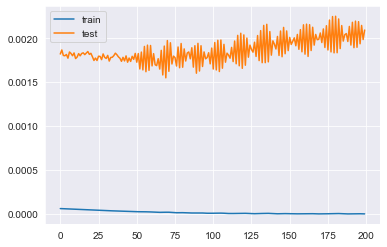

In [73]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Simple prediction

In [75]:
def inverse_predictions(model, scaler, X_train, X_test):
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    
    return train_predict, test_predict    

In [76]:
def metrics(y_train, y_test, train_predict, test_predict):
    print("Train RMSE",math.sqrt(mean_squared_error(y_train,train_predict)))
    print("Test RMSE",math.sqrt(mean_squared_error(y_test,test_predict)))
    

In [77]:
train_predict, test_predict = inverse_predictions(model, scaler, train_X, test_X)

In [78]:
metrics(train_y, test_y, train_predict, test_predict)

Train RMSE 1697484.256882418
Test RMSE 2144522.73529588


### Predict Next N months

In [88]:
def get_forecast(model,x_input,n_steps,steps):
    
    n_features = 1
    
    temp_input=list(x_input)
    lst_output = []
    i = 0
    while (i<steps):
        if(len(temp_input)>n_steps):
            x_input = np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            
            x_input = x_input.reshape((1,n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i, yhat))
            temp_input.append(yhat[0][0])
            temp_input = temp_input[1:]
            lst_output.append(yhat[0][0])
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,n_features))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.append(yhat[0][0])
            lst_output.append(yhat[0][0])
            i=i+1
    print(lst_output)
       
    return pd.DataFrame(lst_output,columns=['prediction'])

In [82]:
x_input=test.reshape(1,-1)
x_input.shape

(1, 54)

In [83]:
x_input

array([[0.47208171, 0.        , 1.        , 0.        , 0.        ,
        0.85964912, 0.21621622, 0.09302326, 0.15384615, 0.64290933,
        0.        , 1.        , 0.        , 0.        , 0.87719298,
        0.2027027 , 0.18604651, 0.15384615, 0.64290933, 0.        ,
        1.        , 0.        , 0.        , 0.87719298, 0.2027027 ,
        0.18604651, 0.15384615, 0.72373208, 0.        , 1.        ,
        0.        , 0.        , 0.88596491, 0.21621622, 0.20930233,
        0.23076923, 0.72373208, 0.        , 1.        , 0.        ,
        0.        , 0.88596491, 0.21621622, 0.20930233, 0.23076923,
        0.85429609, 0.        , 1.        , 0.        , 0.        ,
        0.9122807 , 0.24324324, 0.27906977, 0.23076923]])

In [90]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [89]:
pred = get_forecast(model,temp_input,54,7)

AttributeError: 'list' object has no attribute 'reshape'

In [545]:
scaler.inverse_transform(pred)

array([[ 8260909.98275179],
       [ 9260307.40161359],
       [10141845.46788085],
       [11092782.70507288],
       [12007933.15682626],
       [12936941.68850362],
       [13854743.69734871]])

### Visualizaing the results

In [192]:
pred['actual'][0:3] = podcasts[target][35:38]
pred.head()

,prediction,actual
0,7021140.5,5538401.0
1,7128271.5,6234117.0
2,7114094.0,7358002.0
3,7399844.0,NaN
4,7643847.5,NaN


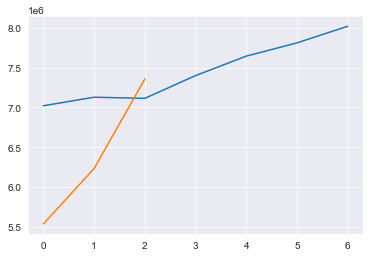

In [196]:
plt.plot(pred)
plt.show()

## Building CNN Models

Uma rede neural convolucional, ou CNN, é um tipo de rede neural desenvolvida para trabalhar com dados de imagens bidimensionais.

O CNN pode ser muito eficaz na extração e aprendizagem automática de recursos de dados de sequência unidimensional, como dados de série temporal univariada.

Um modelo CNN pode ser usado em um modelo híbrido com um backend LSTM, onde o CNN é usado para interpretar subsequências de entrada que, juntas, são fornecidas como uma sequência para um modelo LSTM interpretar. Este modelo híbrido é denominado CNN-LSTM.

A primeira etapa é dividir as sequências de entrada em subsequências que podem ser processadas pelo modelo CNN. Por exemplo, podemos primeiro dividir nossos dados de série temporal univariados em amostras de entrada / saída, com quatro entradas e uma como saída. 

Cada amostra pode então ser dividida em duas subamostras, cada uma com duas etapas de tempo. O CNN pode interpretar cada subsequência de duas etapas de tempo e fornecer uma série de tempo de interpretações das subsequências para o modelo LSTM para processar como entrada.

In [368]:
def build_cnn_model(neurons,n_steps,n_features):
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),input_shape=(None,n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(neurons,return_sequences = True, activation ='relu'))
    model.add(Dense(1))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    
    model.summary()
    
    return model

In [339]:
#define input sequence
time_series = train.values
n_features = 4

X, y = prepare_data(time_series, n_features)

In [340]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
X.shape

(29, 2, 2, 1)

In [369]:
model = build_cnn_model(150,2,1)

Model: "sequential_638"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_119 (TimeDi (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_120 (TimeDi (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_121 (TimeDi (None, None, 64)          0         
_________________________________________________________________
lstm_226 (LSTM)              (None, None, 150)         129000    
_________________________________________________________________
dense_935 (Dense)            (None, None, 1)           151       
Total params: 129,279
Trainable params: 129,279
Non-trainable params: 0
_________________________________________________________________


In [371]:
cnn_model.fit(X, y,epochs=500)# batch_size=15

Epoch 1/500


TypeError: 'NoneType' object is not callable

In [360]:
import gc
gc.collect()

83454